In [1]:
import glob
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from natsort import natsorted, ns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import gridspec
import statistics

In [58]:
def read_data(receptor, ligand, time_limit=0, Verbose=False, exclusions=[]):

    _filein = glob.glob("/home/khlee/work/desmond/output/"+receptor+"/"+ligand+"/%s_*/" % receptor)
    _filein = natsorted(_filein, key=lambda y: y.lower())
    if Verbose:
        print(_filein)
    df = pd.DataFrame()
    for i in range(len(_filein)):
        data = {"Receptor":[], "Ligand":[], "Jobname":[], "Time":[], "Frame":[],
                "Interface":[], "Interface_A":[], "Interface_B":[]}
        if _filein[i].split("/")[-1] in exclusions:
            continue
        try:
            t = np.loadtxt(_filein[i]+'/ene/time.dat')
            frame = list(range(1,len(t)+1))
            obs = pickle.load(open(_filein[i]+'/output/gpcr_interface.p',"rb"))
            obs_a = pickle.load(open(_filein[i]+'/output/gpcr_interface_RA.p',"rb"))
            obs_b = pickle.load(open(_filein[i]+'/output/gpcr_interface_RB.p',"rb"))
        except:
            print("Job not loaded because a file was not found: ",
                  _filein[i].split("/")[-2])
            print("\n")
            continue
        try:
            df_a = pd.read_hdf(_filein[i]+'/output/df_seg_dist_rec_ga.hdf','df')
#             df_b = pd.read_hdf(_filein[i]+'/output/df_seg_dist_rec_rec.hdf','df')
#             angle_ga = pd.read_hdf(_filein[i]+'/output/df_seg_angle_rec_ga.hdf','df')
#             angle_rec = pd.read_hdf(_filein[i]+'/output/df_seg_angle_rec_rec.hdf','df')
        except:
            print("Job not loaded because dataframe file was not found:",
                  _filein[i].split("/")[-2])
            print("\n")
            continue
        
        try:
            assert (len(t)==len(obs)) & (len(obs) == len(obs_a)) & (len(obs) == len(obs_b))
            assert (len(obs) == len(df_a))
#             assert (len(df_a) == len(obs)) & (len(df_b) == len(obs))
#             assert (len(angle_ga) == len(obs)) & (len(angle_rec) == len(obs))
            
            
            temp = pd.DataFrame({"obs":obs, "obs_a":obs_a, "obs_b":obs_b, "t":t, "frame":frame})
            
            sel = list(temp[temp["t"]>=time_limit]["obs"])
            sel_a = list(temp[temp["t"]>=time_limit]["obs_a"])
            sel_b = list(temp[temp["t"]>=time_limit]["obs_b"])
            sel_t = list(temp[temp["t"]>=time_limit]["t"])
            sel_frame = list(temp[temp["t"]>=time_limit]["frame"])
            sel_df_a = df_a.iloc[temp[temp["t"]>=time_limit].index]
#             sel_df_b = df_b.iloc[temp[temp["t"]>=time_limit].index]
#             sel_angle_ga = angle_ga.iloc[temp[temp["t"]>=time_limit].index]
#             sel_angle_rec = angle_rec.iloc[temp[temp["t"]>=time_limit].index]
            
            data["Interface"] += sel
            data["Interface_A"] += sel_a
            data["Interface_B"] += sel_b
            data["Receptor"]+=[receptor for a in range(len(sel))]
            data["Ligand"]+=[ligand for a in range(len(sel))]
            data["Jobname"]+=[_filein[i].split("/")[-2] for a in range(len(sel))]
            data["Time"]+=sel_t
            data["Frame"]+=sel_frame
            i_df = pd.concat([pd.DataFrame(data), sel_df_a.reindex(drop=True)])
#             i_df = pd.concat([pd.DataFrame(data), sel_df_a, sel_df_b, sel_angle_ga, sel_angle_rec], axis=1)
            df = pd.concat([df, i_df])
        except:
            print("Job not loaded because number of datapoints mismatch: ",
                  _filein[i].split("/")[-2])
            print("Time:", len(t), "Interface:", len(obs), "Interface_A:", len(obs_a), "Interface_B:", len(obs_b),
                 "Dist_ga:", len(df_a), "Dist_rec:", len(df_b), "Angle_ga:", len(angle_ga), "Angle_rec:", len(angle_rec))
            print("\n")
            continue
    
    return df

def check_interface(df, receptor=None):
    df["RAB-AB"] = abs(df["Interface"] - (df["Interface_A"]+df["Interface_B"]))
    df["AB"] = df["Interface_A"]+df["Interface_B"]
    df["%Diff"] = abs(df["RAB-AB"]/df["Interface"]*100)
    return df

def read_caller(keywords, exclusions=[]):
    df = pd.DataFrame()
    for pair in keywords:
        df = pd.concat([df,read_data(pair[0],pair[1],exclusions=exclusions)])
    return df

def gen_random_picks(control_seed=2020, num_splits=50, max_value=10000, Verbose = False):
    random_splits = []
    np.random.seed(control_seed)

    for a in range(0,num_splits):
        new_random = np.random.randint(0,max_value)
        #while (new_random in random_splits_old) or (new_random in random_splits):
        while (new_random in random_splits):
            #ensure no duplicate 
            new_random = np.random.randint(0,max_value)
        random_splits.append(new_random)

    #random_splits
    if Verbose:
        for random_split in random_splits:
            print(random_split)
    return random_splits

def bootstrap(df1, df2, splits=1, n=1000, seed=2020):
    sel = pd.DataFrame()
    _splits = gen_random_picks(seed, num_splits=splits)
    for i in range(splits):
        r = gen_random_picks(_splits[i], num_splits=n, max_value=len(df1))
        r2 = gen_random_picks(_splits[i], num_splits=n, max_value=len(df2))
        sel1 = df1.iloc[r]
        sel1["Split"] = [i+1 for j in range(len(sel1))]
        sel2 = df2.iloc[r2]
        sel2["Split"] = [i+1 for j in range(len(sel2))]
        sel = pd.concat([sel,sel1,sel2])
    plt = sns.catplot(x="Split", y="Interface",
                col="System", color='c',
                data=sel, kind="bar",
                height=4, aspect=1.2)

In [51]:
sel_pairs = [("d2gi", "bro"),("d2go", "bro"),("d3gi", "prm"),("d3go", "prm"),("d3gi", "pd"),("d3go", "pd"),
            ("drd3", "prm7"),("drd3", "pd2"),("drd3ao", "prm3"),("drd3ao", "pd2")]
df = read_caller(sel_pairs)
df = check_interface(df)

Job not loaded because number of datapoints mismatch:  d2gi_bro.1


NameError: name 'df_b' is not defined

In [59]:
df = read_data("d2gi", "bro")
df = check_interface(df)
df

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,seg_dist_TM1_H2,seg_dist_TM1_H3,...,seg_dist_7m_H4,seg_dist_7m_H5,seg_dist_7i-H8_H2,seg_dist_7i-H8_H3,seg_dist_7i-H8_HG,seg_dist_7i-H8_H4,seg_dist_7i-H8_H5,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1.0,1469.0,1351.0,132.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1483.0,0.953029
1,d2gi,bro,d2gi_bro.1,0.48,2.0,1412.0,1331.0,88.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1419.0,0.495751
2,d2gi,bro,d2gi_bro.1,0.72,3.0,1471.0,1377.0,108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1485.0,0.951734
3,d2gi,bro,d2gi_bro.1,0.96,4.0,1508.0,1390.0,130.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1520.0,0.795756
4,d2gi,bro,d2gi_bro.1,1.20,5.0,1449.0,1383.0,81.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1464.0,1.035197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.653357,55.172979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.777774,54.529877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.834336,55.342834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.473352,54.933784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
output_dir_root="/home/khlee/desmond/output/d2gi/bro/d2gi_bro.f1"
t = np.loadtxt(output_dir_root+'/ene/time.dat')
output_dir=output_dir_root+"/output"
df = pd.read_hdf(output_dir+'/df_seg_angle_rec_rec.hdf','df')
df

,seg_angle_1e_1e,seg_angle_1e_1m,seg_angle_1e_1i,seg_angle_1e_2i,seg_angle_1e_2m,seg_angle_1e_2e,seg_angle_1e_3e,seg_angle_1e_3m,seg_angle_1e_3i,seg_angle_1e_4i,...,seg_angle_7i-H8_4e,seg_angle_7i-H8_5e,seg_angle_7i-H8_5m,seg_angle_7i-H8_5i,seg_angle_7i-H8_6i,seg_angle_7i-H8_6m,seg_angle_7i-H8_6e,seg_angle_7i-H8_7e,seg_angle_7i-H8_7m,seg_angle_7i-H8_7i-H8
0,0.0,0.157732,0.233827,2.676126,2.793785,2.787676,1.071497,0.940393,0.625515,2.738689,...,1.919097,1.143675,1.153504,1.105177,2.276748,2.673780,2.788391,0.309550,0.294728,0.0
1,0.0,0.144452,0.280206,2.670699,2.705788,2.726563,1.099003,0.627901,0.593915,2.774219,...,1.812654,1.050000,1.055666,1.236017,2.123251,2.609083,2.876286,0.641600,0.397864,0.0
2,0.0,0.133342,0.314239,2.806481,2.910340,2.601709,0.887775,0.698204,0.487751,2.762316,...,2.016761,1.072166,1.049876,1.120180,2.235618,2.679205,2.729097,0.466848,0.404414,0.0
3,0.0,0.079428,0.180433,2.643796,2.750824,2.789796,1.074010,0.842701,0.664708,2.726295,...,2.057173,1.153002,1.103570,1.191007,2.218179,2.679308,2.844186,0.435963,0.485673,0.0
4,0.0,0.060872,0.257732,2.661497,2.785430,2.606108,1.154932,0.900952,0.681109,2.748923,...,1.941783,1.264366,1.146296,1.159343,2.158918,2.741361,2.823554,0.600496,0.505508,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.077830,0.306724,2.798334,3.010075,2.782455,0.909506,0.569897,0.508788,2.645176,...,2.122562,1.081866,0.890263,0.996657,2.332300,2.907551,2.894653,0.364710,0.488690,0.0
596,0.0,0.047462,0.350695,2.879704,2.887971,2.806063,0.854437,0.575506,0.443322,2.776524,...,1.985627,1.319515,1.168503,1.203860,2.115876,2.670565,2.793048,0.583825,0.579385,0.0
597,0.0,0.214646,0.434457,2.754445,2.855316,2.696806,0.912645,0.593231,0.515868,2.987298,...,1.906892,1.088709,1.104307,1.124118,2.238737,2.612801,2.704394,0.454305,0.380442,0.0
598,0.0,0.139383,0.333395,2.788662,2.866318,2.805640,0.938892,0.719165,0.459013,2.849314,...,1.779361,1.277237,1.385749,1.289122,2.068919,2.524288,2.708546,0.734137,0.801984,0.0


In [44]:
df2 = pd.read_hdf(output_dir+'/df_seg_dist_rec_ga.hdf','df')
df2

,seg_dist_1e_H2,seg_dist_1e_H3,seg_dist_1e_HG,seg_dist_1e_H4,seg_dist_1e_H5,seg_dist_1m_H2,seg_dist_1m_H3,seg_dist_1m_HG,seg_dist_1m_H4,seg_dist_1m_H5,...,seg_dist_7m_H2,seg_dist_7m_H3,seg_dist_7m_HG,seg_dist_7m_H4,seg_dist_7m_H5,seg_dist_7i-H8_H2,seg_dist_7i-H8_H3,seg_dist_7i-H8_HG,seg_dist_7i-H8_H4,seg_dist_7i-H8_H5
0,68.701623,66.756249,84.393348,70.838808,56.753990,56.024959,54.858466,74.111959,60.678696,45.957943,...,54.919174,52.866596,69.652800,56.341280,39.849774,36.010772,35.454405,56.440300,43.537878,28.518476
1,68.252091,66.960666,85.094478,71.606897,57.402847,55.602293,55.073763,74.701947,61.422192,46.662524,...,55.086209,53.638340,70.677168,57.452442,40.902520,35.609292,35.431890,56.396139,43.696560,28.787335
2,67.736979,66.455687,84.789007,71.326123,56.916915,54.999278,54.564778,74.313116,61.049988,45.743557,...,54.612687,53.208006,70.541011,57.299035,40.468494,35.607103,35.375260,56.372558,43.612584,28.392500
3,68.853667,66.947280,85.095461,71.478680,57.398138,56.092665,55.105993,74.911541,61.467209,46.592867,...,55.323029,53.383289,70.658981,57.272910,40.760831,35.839776,35.259642,56.508456,43.600171,28.574191
4,68.378646,67.276500,85.515500,72.270074,58.007122,55.460824,55.010769,74.503291,61.416983,46.536680,...,55.244530,53.893044,70.857910,57.869604,41.196022,35.706435,35.581033,56.364561,43.773580,28.752934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,70.743943,68.477969,86.991307,73.395812,60.064606,57.128095,55.241782,74.781103,61.282076,47.443001,...,55.721201,53.111679,70.459580,57.000540,41.268924,36.559942,34.230957,54.857797,41.684977,29.122274
596,69.442187,67.881428,86.216922,72.775084,59.562135,56.217126,54.913525,74.061135,60.707841,47.065357,...,55.363488,53.258597,70.104478,56.769539,41.213682,35.621834,33.980752,54.311719,41.319447,28.663822
597,70.605818,68.592061,86.379193,72.915014,59.384842,57.131402,55.494071,74.392884,61.024278,47.261425,...,55.749927,53.296626,69.967610,56.661896,40.950690,36.215514,34.162055,54.107937,41.074398,28.162857
598,68.728642,67.306219,85.660043,72.124921,59.284857,55.306160,54.268916,73.651482,60.232442,46.888891,...,54.912282,52.940381,70.146843,56.667315,41.440108,34.724286,33.271845,53.672642,40.632427,27.909971


In [42]:
df[df["Jobname"]=="d2gi_bro.f1"]

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,seg_dist_TM1_H2,seg_dist_TM1_H3,...,seg_angle_7i-H8_5i,seg_angle_7i-H8_6i,seg_angle_7i-H8_6m,seg_angle_7i-H8_6e,seg_angle_7i-H8_7e,seg_angle_7i-H8_7m,seg_angle_7i-H8_7i-H8,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.f1,0.6,1,1654.0,1512.0,149.0,NaN,NaN,...,1.105177,2.276748,2.673780,2.788391,0.309550,0.294728,0.0,7.0,1661.0,0.423216
1,d2gi,bro,d2gi_bro.f1,1.2,2,1560.0,1397.0,174.0,NaN,NaN,...,1.236017,2.123251,2.609083,2.876286,0.641600,0.397864,0.0,11.0,1571.0,0.705128
2,d2gi,bro,d2gi_bro.f1,1.8,3,1587.0,1421.0,171.0,NaN,NaN,...,1.120180,2.235618,2.679205,2.729097,0.466848,0.404414,0.0,5.0,1592.0,0.315060
3,d2gi,bro,d2gi_bro.f1,2.4,4,1554.0,1390.0,172.0,NaN,NaN,...,1.191007,2.218179,2.679308,2.844186,0.435963,0.485673,0.0,8.0,1562.0,0.514801
4,d2gi,bro,d2gi_bro.f1,3.0,5,1558.0,1403.0,164.0,NaN,NaN,...,1.159343,2.158918,2.741361,2.823554,0.600496,0.505508,0.0,9.0,1567.0,0.577664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,d2gi,bro,d2gi_bro.f1,357.6,596,1523.0,1469.0,59.0,NaN,NaN,...,0.996657,2.332300,2.907551,2.894653,0.364710,0.488690,0.0,5.0,1528.0,0.328299
596,d2gi,bro,d2gi_bro.f1,358.2,597,1556.0,1509.0,47.0,NaN,NaN,...,1.203860,2.115876,2.670565,2.793048,0.583825,0.579385,0.0,0.0,1556.0,0.000000
597,d2gi,bro,d2gi_bro.f1,358.8,598,1551.0,1512.0,39.0,NaN,NaN,...,1.124118,2.238737,2.612801,2.704394,0.454305,0.380442,0.0,0.0,1551.0,0.000000
598,d2gi,bro,d2gi_bro.f1,359.4,599,1555.0,1518.0,37.0,NaN,NaN,...,1.289122,2.068919,2.524288,2.708546,0.734137,0.801984,0.0,0.0,1555.0,0.000000


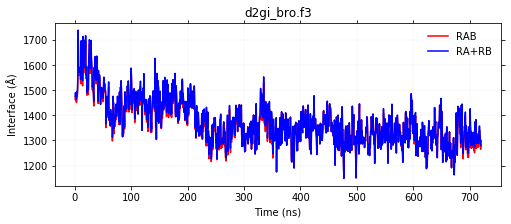

In [38]:
sel_job = "d2gi_bro.f3"
df2 = df[df["Jobname"] == sel_job]
t = df2["Time"]
RAB = df2["Interface"]
AB = df2["AB"]
title = sel_job

nrow = 1
ncol = 1
figheight = 3
figwidth = 8
linewidth = 1

fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

ax1.plot(t, RAB, label="RAB",color="red")
ax1.plot(t, AB, label="RA+RB",color="blue")
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Interface (Å)")
ax1.set_title(title)
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)



No handles with labels found to put in legend.


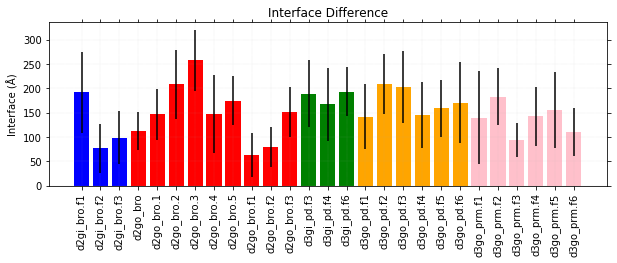

In [86]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["RAB-AB"]))
    stdev.append(statistics.stdev(indf2["RAB-AB"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



No handles with labels found to put in legend.


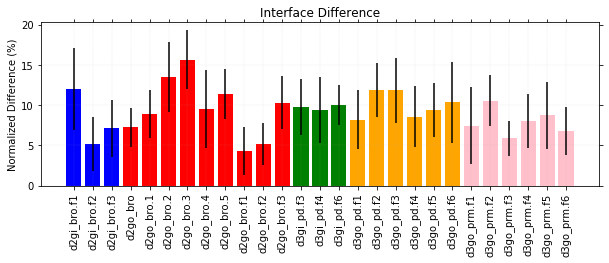

In [82]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["%Diff"]))
    stdev.append(statistics.stdev(indf2["%Diff"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Normalized Difference (%)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



No handles with labels found to put in legend.


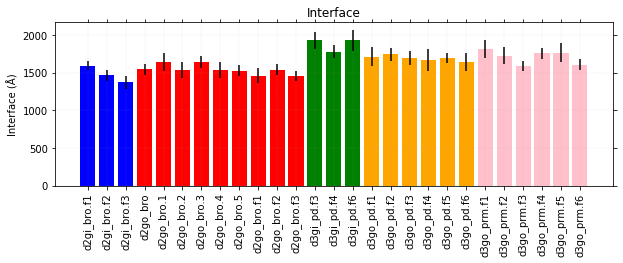

In [87]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["Interface"]))
    stdev.append(statistics.stdev(indf2["Interface"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



In [113]:
df

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.f1,0.6,1.0,1654.0,1512.0,149.0,291.0,1661.0,17.593712
1,d2gi,bro,d2gi_bro.f1,1.2,2.0,1560.0,1397.0,174.0,337.0,1571.0,21.602564
2,d2gi,bro,d2gi_bro.f1,1.8,3.0,1587.0,1421.0,171.0,337.0,1592.0,21.235035
3,d2gi,bro,d2gi_bro.f1,2.4,4.0,1554.0,1390.0,172.0,336.0,1562.0,21.621622
4,d2gi,bro,d2gi_bro.f1,3.0,5.0,1558.0,1403.0,164.0,319.0,1567.0,20.474968
...,...,...,...,...,...,...,...,...,...,...,...
13595,d3go,pd,d3go_pd.f6,1197.6,1996.0,1661.0,1602.0,59.0,118.0,1661.0,7.104154
13596,d3go,pd,d3go_pd.f6,1198.2,1997.0,1580.0,1543.0,37.0,74.0,1580.0,4.683544
13597,d3go,pd,d3go_pd.f6,1198.8,1998.0,1621.0,1578.0,43.0,86.0,1621.0,5.305367
13598,d3go,pd,d3go_pd.f6,1199.4,1999.0,1558.0,1507.0,51.0,102.0,1558.0,6.546855
